In [111]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime

major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [112]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[6]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
# display(data.head())
# display(data.tail())
print(data.shape)
# display(data)
test_size = 0.048 # m15
# test_size = 0.143 # m5
test_len = int(test_size * len(data))
print("test length", test_len)
# train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
# data = train_data
# data = test_data
# print(data.shape)
display(data)

NZD/USD
(10000, 13)
test length 480


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-20 09:30:00,0.69119,0.69141,0.69150,0.69074,0.69139,0.69160,0.69171,0.69094,1418,0.691290,0.691605,0.690840,0.691505
2021-07-20 09:45:00,0.69141,0.69050,0.69157,0.69034,0.69160,0.69069,0.69177,0.69053,1981,0.691505,0.691670,0.690435,0.690595
2021-07-20 10:00:00,0.69050,0.69061,0.69096,0.68977,0.69069,0.69080,0.69113,0.68996,2029,0.690595,0.691045,0.689865,0.690705
2021-07-20 10:15:00,0.69061,0.69050,0.69099,0.69002,0.69080,0.69071,0.69117,0.69020,1986,0.690705,0.691080,0.690110,0.690605
2021-07-20 10:30:00,0.69050,0.69062,0.69072,0.69019,0.69071,0.69080,0.69092,0.69037,1228,0.690605,0.690820,0.690280,0.690710
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-10 20:45:00,0.67948,0.67964,0.67969,0.67942,0.67968,0.67984,0.67990,0.67962,541,0.679580,0.679795,0.679520,0.679740
2021-12-10 21:00:00,0.67965,0.67971,0.67977,0.67958,0.67985,0.67991,0.67997,0.67978,391,0.679750,0.679870,0.679680,0.679810
2021-12-10 21:15:00,0.67970,0.67980,0.67981,0.67966,0.67989,0.68000,0.68004,0.67987,156,0.679795,0.679925,0.679765,0.679900


In [113]:
aroon = ta.trend.AroonIndicator(close=data['close'], window=25, fillna=False)

In [114]:
data['aroon_up'] = aroon.aroon_up()
data['aroon_down'] = aroon.aroon_down()
data['aroon_ind'] = aroon.aroon_indicator()
data.dropna(inplace=True)

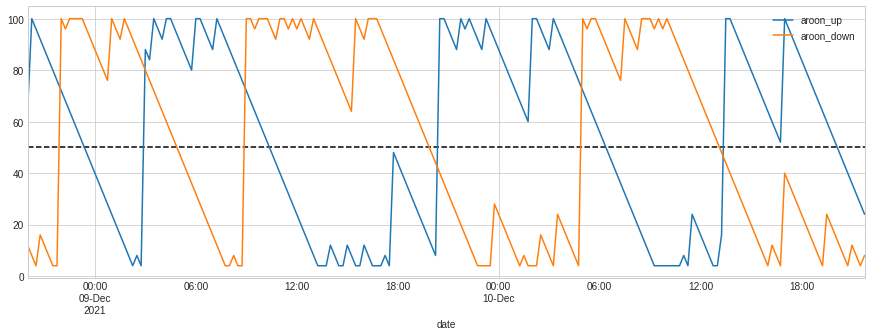

In [115]:
ax = data[['aroon_up', 'aroon_down']].iloc[-200:].plot(figsize=(15,5))
plt.hlines(y=50, xmin=data.iloc[-200:].index[0], xmax=data.iloc[-200:].index[-1], colors='k', linestyles="--")
plt.show()

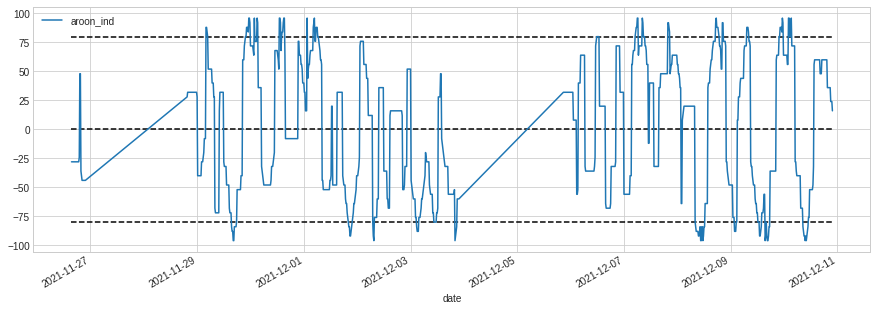

In [116]:
ax = data[['aroon_ind']].iloc[-1000:].plot(figsize=(15,5))
plt.hlines(y=0, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.hlines(y=80, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.hlines(y=-80, xmin=data.iloc[-1000:].index[0], xmax=data.iloc[-1000:].index[-1], colors='k', linestyles="--")
plt.show()

In [117]:
if data.shape[0] > test_len:
    data = data.iloc[-test_len:]
else:
    pass

In [118]:
# aroon up > 50 and aroon down < 50 --> long
# aroon up < 50 and aroon down > 50 --> short
# else --> 0
threshold = 50
data['aroon_signal'] = np.where(np.all([data['aroon_up']>threshold, data['aroon_down']<threshold], axis=0), 1,
                       np.where(np.all([data['aroon_up']<threshold, data['aroon_down']>threshold], axis=0), -1, 0))

In [119]:
print(data['aroon_signal'].value_counts())
print("-"*50)
print(data['aroon_signal'].diff(1).apply(np.abs).value_counts())

 1    222
-1    147
 0    111
Name: aroon_signal, dtype: int64
--------------------------------------------------
0.0    431
1.0     48
Name: aroon_signal, dtype: int64


  0%|          | 0/479 [00:00<?, ?it/s]

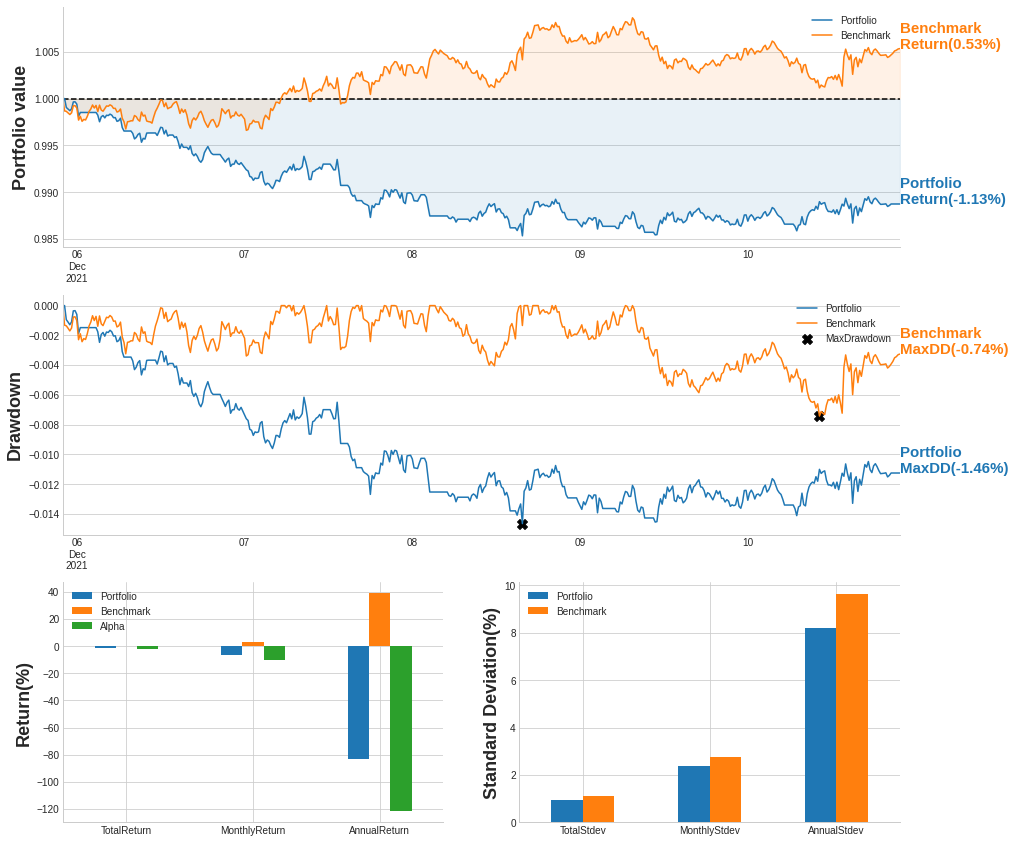

----------------------------------------------------------------------
Data length: |4 days 23:45:00|
Data range from |2021-12-05 22:00:00| to |2021-12-10 21:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤══════════╕
│               │   Portfolio │   Benchmark │    Alpha │
╞═══════════════╪═════════════╪═════════════╪══════════╡
│ TotalReturn   │      -1.133 │       0.534 │   -1.667 │
├───────────────┼─────────────┼─────────────┼──────────┤
│ MonthlyReturn │      -6.814 │       3.208 │  -10.022 │
├───────────────┼─────────────┼─────────────┼──────────┤
│ AnnualReturn  │     -82.900 │      39.030 │ -121.931 │
╘═══════════════╧═════════════╧═════════════╧══════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStde

In [120]:
backtest = IterativeBacktester(data, data['aroon_signal'], freq)
backtest.backtest()
backtest.results()